In [18]:
import pandas as pd
import numpy as np 

from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from scipy import stats
from scipy.spatial.distance import pdist

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from itertools import cycle

import string

from collections import Counter

In [19]:
from keras.layers.embeddings import Embedding
from keras.layers import Input, merge
from keras.models import Model
from keras.layers.core import Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization


from keras.layers.merge import Concatenate

from keras.regularizers import l1, l2

from keras.layers.recurrent import GRU, LSTM

from keras import backend as K

In [20]:
org_ratings = pd.read_csv('ratings_latest.csv')
org_movies = pd.read_csv('metadata.csv')
org_ratings.head(), org_movies.head()

(                  id  rate  appid
 0  76561197960265729   1.0     10
 1  76561197960265729   1.0     20
 2  76561197960265729   1.0     30
 3  76561197960265729   1.0     40
 4  76561197960265729   1.0     50,    appid                    appname genres
 0     10             Counter-Strike     1/
 1     20      Team Fortress Classic     1/
 2     30              Day of Defeat     1/
 3     40         Deathmatch Classic     1/
 4     50  Half-Life: Opposing Force     1/)

In [21]:
users = org_ratings.id.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}


games = org_ratings.appid.unique()
game_map = {i:val for i,val in enumerate(games)}
inverse_game_map = {val:i for i,val in enumerate(games)}

org_ratings["id"] = org_ratings["id"].map(inverse_user_map)

org_ratings["old_id"] = org_ratings["appid"] # copying for join with metadata
org_ratings["appid"] = org_ratings["appid"].map(inverse_game_map)

print ("A total of: ", users.shape[0], "unique users")
print ("A total of: ", games.shape[0], "unique games")

A total of:  676668 unique users
A total of:  18865 unique games


In [22]:
users = org_ratings.id.unique()
games = org_ratings.appid.unique()
rating = org_ratings.rate.unique()
len(users), len(games), len(rating)

(676668, 18865, 100)

In [23]:
userid2idx = {o:i for i,o in enumerate(users)}
gameid2idx = {o:i for i,o in enumerate(games)}
gameidx2id = {i:o for i,o in enumerate(games)}

In [24]:
new_ratings = org_ratings.copy()

new_ratings.gameId = org_ratings.appid.apply(lambda x: gameid2idx[x])
new_ratings.userId = org_ratings.id.apply(lambda x: userid2idx[x])

In [25]:
msk = np.random.rand(len(new_ratings)) < 0.8

train = new_ratings[msk]
valid = new_ratings[~msk]

In [26]:
print(train.shape, valid.shape)
print(train.head())

(20588105, 4) (5145823, 4)
   id  rate  appid  old_id
0   0   1.0      0      10
1   0   1.0      1      20
2   0   1.0      2      30
3   0   1.0      3      40
4   0   1.0      4      50


In [27]:
user_input = Input(shape=(1,), dtype='int64', name='user_input')
game_input = Input(shape = (1,), dtype = 'int64', name = 'game_input')

In [28]:
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
game_embed = Embedding(len(games), 50, input_length =1)(game_input)

In [29]:
# x = merge([user_embed, game_embed], mode='concat')
x = Concatenate()([user_embed, game_embed])

In [30]:
user_input = Input(shape=(1,), dtype='int64', name='user_input')
game_input = Input(shape = (1,), dtype = 'int64', name = 'game_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
game_embed = Embedding(len(games), 50, input_length =1)(game_input)
x = Concatenate()([user_embed, game_embed])
 
# x = Dropout(0.25)(x)
# BatchNormalization()
# x = LSTM(70)(x)
# x = Dropout(0.25)(x)
# BatchNormalization()

x = Dropout(0.25)(x)
BatchNormalization()
x_fwd = LSTM(40)(x)
x_bwd = LSTM(40, go_backwards = True)(x)
# x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x_bdir = Concatenate()([x_fwd, x_bwd])
x = Dropout(0.25)(x_bdir)
BatchNormalization()
x = Dense(1)(x)
LSTM_nn = Model([user_input, game_input], x)


In [31]:
LSTM_nn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [32]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error

# initial_train_preds = LSTM_nn.predict([train["id"], train["appid"]])
# print("Initial train MSE: %0.3f" % mean_squared_error(initial_train_preds, train["rate"]))
# print("Initial train MAE: %0.3f" % mean_absolute_error(initial_train_preds, train["rate"]))

In [33]:
# initial_test_preds = LSTM_nn.predict([test["id"], test["appid"]])
# print("Initial test MSE: %0.3f" % mean_squared_error(initial_test_preds, test["rate"]))
# print("Initial test MAE: %0.3f" % mean_absolute_error(initial_test_preds, test["rate"]))

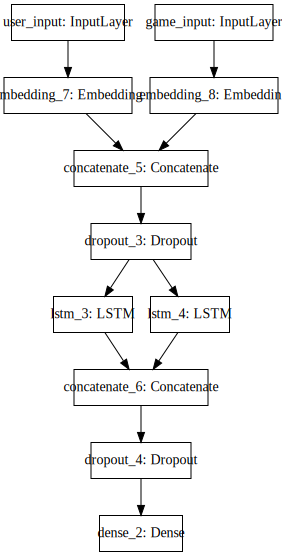

In [34]:

from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(LSTM_nn).create(prog='dot', format='svg'))

In [37]:

LSTM_history = LSTM_nn.fit([train.id, train.appid], train.rate, batch_size=64, epochs=10, 
          validation_data=([valid.id, valid.appid], valid.rate), verbose = 1)

In [ ]:
import pickle

with open('lstmbirnn70.pkl' , 'wb') as file_pi:
    pickle.dump(LSTM_history.history, file_pi)

In [ ]:
model.save('lstmbirnn70.h5')

In [ ]:
final_train_preds = LSTM_nn.predict([train["id"], train["appid"]])
print("Initial train MSE: %0.3f" % mean_squared_error(final_train_preds, train["rate"]))
print("Initial train MAE: %0.3f" % mean_absolute_error(final_train_preds, train["rate"]))

In [ ]:
final_test_preds = LSTM_nn.predict([test["id"], test["appid"]])
print("Initial test MSE: %0.3f" % mean_squared_error(final_test_preds, test["rate"]))
print("Initial test MAE: %0.3f" % mean_absolute_error(final_test_preds,test["rate"]))